In [5]:
import os, sys
import pickle
sys.path.append("../")

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib import gridspec
from matplotlib import ticker
import seaborn as sns
import numpy as np
from scipy.integrate import cumtrapz
from tqdm import *

from grf.grf import PerturbedProbability, FIRAS
from grf.pk_interp import PowerSpectrumGridInterpolator
from grf.units import *

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Load plot settings

from plot_params import params
pylab.rcParams.update(params)

cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

/Users/smsharma/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/smsharma/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [7]:
# Where to save plots
plots_dir = "../paper/draft-formalism/plots/"

## Plot of d$P$/d$z$ at high redshifts

In [8]:
# Load nonlinear matter spectrum with a baryon Jeans scale suppression

log_b_pspec = PowerSpectrumGridInterpolator("lin_baryon_500")
log_e_pspec = PowerSpectrumGridInterpolator("lin_electron_500")
log_b_e_pspec = PowerSpectrumGridInterpolator("lin_baryon_electron_500")

In [9]:
firas = FIRAS(log_b_pspec, log_e_pspec, log_b_e_pspec)  # Also load a FIRAS class to access the FIRAS frequencies, as benchmarks
firas_nochi = FIRAS(log_b_pspec,)  # Also load a FIRAS class to access the FIRAS frequencies, as benchmarks

../grf/grf.py:633: FutureWarning: read_table is deprecated, use read_csv instead.
  names=['freq', 'I', 'residual', 'uncert', 'poles'])


In [10]:
z_homo_ary = [100, 200, 300, 400, 500, 600]

In [11]:
cols_seq = sns.color_palette("Reds")
cols_seq_2 = sns.color_palette("Blues")

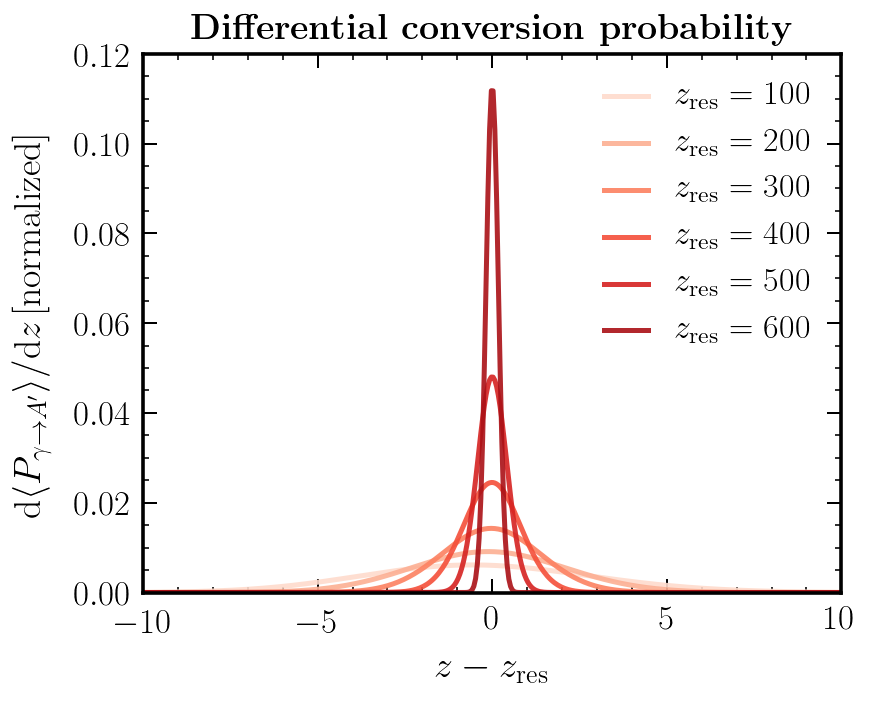

In [12]:
for i_z, z in enumerate(z_homo_ary):
    
    # Dark photon mass 
    m_Ap = np.sqrt(firas.m_A_sq(z, firas.omega_FIRAS[0] * (1 + z)))  

    # Frequencies of interest (we are only going to plot results corresponding to the lower frequency)
    omega_ary = firas.omega_FIRAS

    # Get homogeneous crossings
    z_homogeneous_crossings = firas.get_z_crossings(m_Ap, omega_ary[0], evolve_z=True)[-1]
    
    z_ary = np.linspace(z_homogeneous_crossings - 10, z_homogeneous_crossings + 10, 400)  # np.logspace(np.log10(400), np.log10(1000), 1000)

    dPdz = firas._dP_dz(z_ary=z_ary, m_Ap=m_Ap, k_min=1e-3, k_max=1000, omega=omega_ary, pdf='gaussian')[0][0]
    dPdz /= np.sum(dPdz)

    # Using Gaussian PDF
    plt.plot(z_ary - z_homogeneous_crossings, dPdz, label=r"$z_\mathrm{res}=" + str(z) + "$", color=cols_seq[i_z])

plt.xlim(-10, 10)
plt.ylim(0, 0.12)

plt.xlabel("$z - z_\mathrm{res}$")
plt.ylabel(r"$\mathrm{d}\langle P_{\gamma\to A'}\rangle/\mathrm{d} z$\,[normalized]")

plt.title(r"\bf{Differential conversion probability}")

plt.legend(handlelength=1.3)

plt.tight_layout()
plt.savefig(plots_dir + "dP_dz_highz.pdf")

## Width of resonance plot 

In [19]:
z_ary = np.logspace(np.log10(50), np.log10(900), 100)

In [68]:
sigma_z_ary = []
sigma_z_no_x_e_ary = []

for z in tqdm_notebook(z_ary):
    
    m_Ap = np.sqrt(firas.m_A_sq(z, firas.omega_FIRAS[0] * (1 + z)))  
    z_search_ary = np.linspace(z - 10, z + 10, 100000)
    m_Ap_search_ary = np.sqrt(firas.m_A_sq(z_search_ary, firas.omega_FIRAS[0] * (1 + z_search_ary)))  

    # Frequencies of interest (we are only going to plot results corresponding to the lower frequency)
    omega_ary = firas.omega_FIRAS

    # Get homogeneous crossings, to see where they are!
    z_homogeneous_crossings = firas.get_z_crossings(m_Ap, omega_ary[0], evolve_z=True)[-1]

    sigma_sq = firas._dP_dz(z_ary=[z_homogeneous_crossings], m_Ap=m_Ap, k_min=1e-3, k_max=800, omega=omega_ary, pdf='gaussian')[1][0]

    delta_sq_abs = np.abs(m_Ap ** 2 - m_Ap_search_ary ** 2)
    
    fudge = 1 / 2.
    
    where_ary = np.where(np.logical_or(
        (delta_sq_abs[:-1] < fudge * sigma_sq ** 0.5) * (delta_sq_abs[1:] > fudge * sigma_sq ** 0.5), (delta_sq_abs[:-1] > fudge * sigma_sq ** 0.5) * (delta_sq_abs[1:] < fudge * sigma_sq ** 0.5)))
    
    sigma_z_ary.append(np.diff(z_search_ary[where_ary])[-1])
    
    sigma_sq = firas_nochi._dP_dz(z_ary=[z_homogeneous_crossings], m_Ap=m_Ap, k_min=1e-3, k_max=1000, omega=omega_ary, pdf='gaussian')[1][0]

    delta_sq_abs = np.abs(m_Ap ** 2 - m_Ap_search_ary ** 2)

    where_ary = np.where(np.logical_or(
        (delta_sq_abs[:-1] < fudge * sigma_sq ** 0.5) * (delta_sq_abs[1:] > fudge * sigma_sq ** 0.5), (delta_sq_abs[:-1] > fudge * sigma_sq ** 0.5) * (delta_sq_abs[1:] < fudge * sigma_sq ** 0.5)))

    sigma_z_no_x_e_ary.append(np.diff(z_search_ary[where_ary])[-1])

sigma_z_ary = np.array(sigma_z_ary)
sigma_z_no_x_e_ary = np.array(sigma_z_no_x_e_ary)

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [69]:
log_pspec_lin_baryon = PowerSpectrumGridInterpolator("lin_baryon")
firas_no_x_e = FIRAS(log_b_pspec) 

sigma_sq_no_x_e = firas_no_x_e._dP_dz(z_ary=z_ary, m_Ap=m_Ap, k_min=1e-3, k_max=800, omega=omega_ary, pdf='gaussian')[1][0]
m_A_sq = firas_no_x_e.m_A_sq(z_ary, omega_ary[0]) 
sigma_ary = np.sqrt(sigma_sq_no_x_e /  m_A_sq ** 2)
delta_z_ary = 3.3 * ((1 + z_ary) / 100.) * sigma_ary / 0.1

In [70]:
from scipy.misc import derivative
delta_z_full_approx_ary = sigma_ary * np.array([derivative(lambda z: np.log(firas_no_x_e.m_A_sq(z, firas_no_x_e.omega_FIRAS[0])), x0=z, dx=z * 1e-2) for z in z_ary]) ** -1

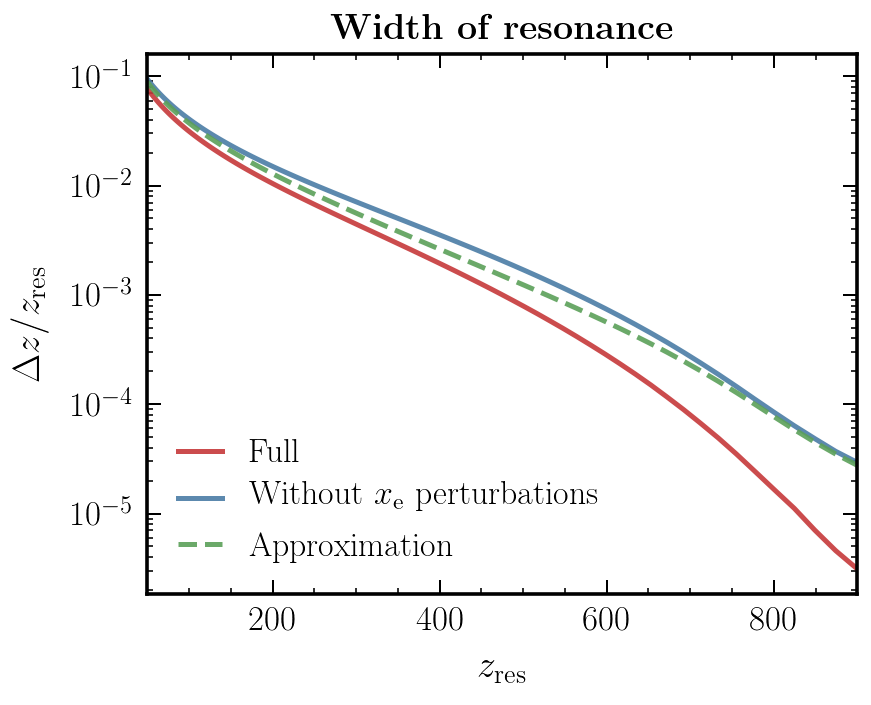

In [76]:
plt.plot(z_ary, sigma_z_ary / z_ary, label="Full")
plt.plot(z_ary, sigma_z_no_x_e_ary / z_ary, label=r"Without $x_\mathrm{e}$ perturbations")
# plt.plot(z_ary, delta_z_ary / z_ary, label="Eq. 37", ls='--')
plt.plot(z_ary, delta_z_full_approx_ary / z_ary, label="Approximation", ls='--')

plt.yscale("log")
plt.xlim(min(z_ary), max(z_ary))
plt.xlabel(r"$z_\mathrm{res}$")
plt.ylabel(r"$\Delta z / z_\mathrm{res}$")

plt.title(r"\textbf{Width of resonance}")

plt.legend(handlelength=1.3)

plt.tight_layout()
plt.savefig(plots_dir + "sigma_z_res.pdf")

## Variance of fluctuations plot

In [17]:
log_pspec_franken_lower = PowerSpectrumGridInterpolator("franken_lower")
firas_franken_lower = FIRAS(log_pspec_franken_lower) 

log_pspec_franken_upper = PowerSpectrumGridInterpolator("franken_upper")
firas_franken_upper = FIRAS(log_pspec_franken_upper) 

log_pspec_lin_baryon = PowerSpectrumGridInterpolator("lin_baryon")
firas_no_x_e = FIRAS(log_b_pspec) 
firas_with_x_e = FIRAS(log_b_pspec, log_e_pspec, log_b_e_pspec) 

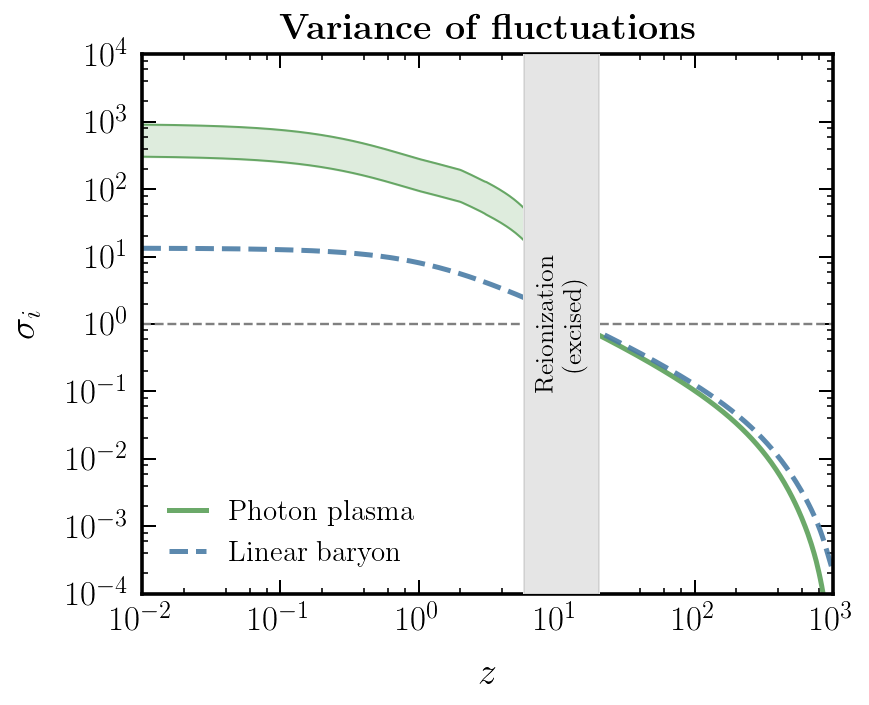

In [18]:
z_ary = np.logspace(np.log10(1e-2), np.log10(6), 1000)
m_A_sq = firas.m_A_sq(z_ary, omega_ary[0]) 

sigma_sq_franken_lower = firas_franken_lower._dP_dz(z_ary=z_ary, m_Ap=m_Ap, k_min=1e-3, k_max=3000, omega=omega_ary, pdf='gaussian')[1][0]
sigma_sq_franken_upper = firas_franken_upper._dP_dz(z_ary=z_ary, m_Ap=m_Ap, k_min=1e-3, k_max=3000, omega=omega_ary, pdf='gaussian')[1][0]

sigma_sq = firas._dP_dz(z_ary=z_ary, m_Ap=m_Ap, k_min=1e-3, k_max=3000, omega=omega_ary, pdf='gaussian')[1][0]
plt.fill_between(z_ary, np.sqrt(sigma_sq_franken_lower / m_A_sq ** 2), 
                np.sqrt(sigma_sq_franken_upper /  m_A_sq ** 2),
                color=cols_default[2], alpha=0.2)

plt.plot(z_ary, np.sqrt(sigma_sq_franken_lower / m_A_sq ** 2), color=cols_default[2], lw=1)
plt.plot(z_ary, np.sqrt(sigma_sq_franken_upper / m_A_sq ** 2), color=cols_default[2], lw=1)

z_ary = np.logspace(np.log10(1e-2), np.log10(1000), 1000)
m_A_sq = firas.m_A_sq(z_ary, omega_ary[0]) 

sigma_sq_no_x_e = firas_no_x_e._dP_dz(z_ary=z_ary, m_Ap=m_Ap, k_min=1e-3, k_max=1000, omega=omega_ary, pdf='gaussian')[1][0]
sigma_sq_with_x_e = firas_with_x_e._dP_dz(z_ary=z_ary, m_Ap=m_Ap, k_min=1e-3, k_max=1000, omega=omega_ary, pdf='gaussian')[1][0]

plt.plot(z_ary[z_ary > 7], np.sqrt(sigma_sq_with_x_e /  m_A_sq ** 2)[z_ary > 7], color=cols_default[2], label=r"Photon plasma")
plt.plot(z_ary, np.sqrt(sigma_sq_no_x_e /  m_A_sq ** 2), color=cols_default[1], label="Linear baryon", ls='--')

plt.axhline(1, ls='--', color='grey', lw=1.2)

offset = -0.2
a1 = plt.axvspan(6 + offset, 20 - offset, color='white', alpha=1)
a1.set_zorder(20)
a2 = plt.axvspan(6 + offset, 20 - offset, color='grey', alpha=0.2)
a2.set_zorder(21)
a3 = plt.text(10 ** ((np.log10(6) + np.log10(20)) / 2.), 1e0, "Reionization \n(excised)", rotation=90, fontsize=13, multialignment="center", va="center", ha="center")
a3.set_zorder(22)

plt.legend(fontsize=14.5, handlelength=1.3)

plt.xscale("log")
plt.yscale("log")

plt.xlim(1e-2, 1000)
plt.ylim(1e-4, 1e4)

plt.xlabel("$z$")
plt.ylabel(r"$\sigma_i$")

plt.title(r"\bf{Variance of fluctuations}")

ax = plt.gca()

locmaj = ticker.LogLocator(base=10,numticks=12) 
ax.xaxis.set_major_locator(locmaj)

locmin = ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(ticker.NullFormatter())

locmaj = ticker.LogLocator(base=10,numticks=12) 
ax.yaxis.set_major_locator(locmaj)

locmin = ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8), numticks=12)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(ticker.NullFormatter())

plt.tight_layout()
plt.savefig(plots_dir + "sigma_all.pdf")